<a href="https://colab.research.google.com/github/yuriborg/time_series/blob/main/Univariate_Time_Series_Forecasting_Simple_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

  -  Plotting ACF and PACF
  - Forecasting Univariate time series data with Exponential Smoothing
  - Forecasting Univariate time series data with non-Seasonal ARIMA
  - Forecasting Univariate time series data with Seasonal ARIMA

  Statistical Time Series Models: AR(Auto Regressive), MA(Moving Average), ARMA(Auto Regressive Moving Average), ARIMA(Auto Regressive Integrated Moving Average), SARIMA(Seaso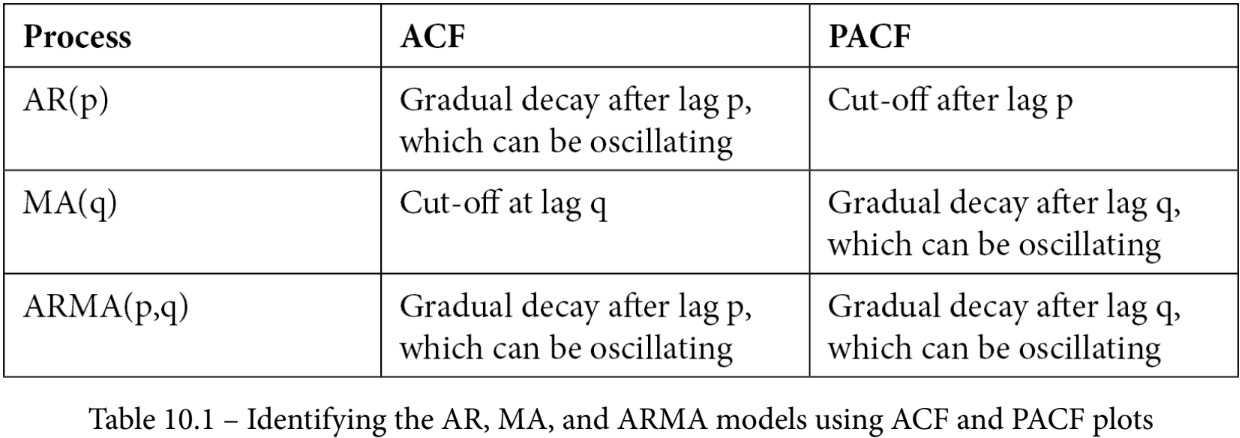nal Auto Regressive Moving Average)

# Imports

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

# Data Extraction

In [159]:
milk = pd.read_csv('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv',
                    parse_dates=True)
life = pd.read_csv('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv',
                   parse_dates = True)

  - Visually inspecting if the Time Series has any Trend or Seasonality

<Axes: title={'center': 'Monthly Milk Production'}>

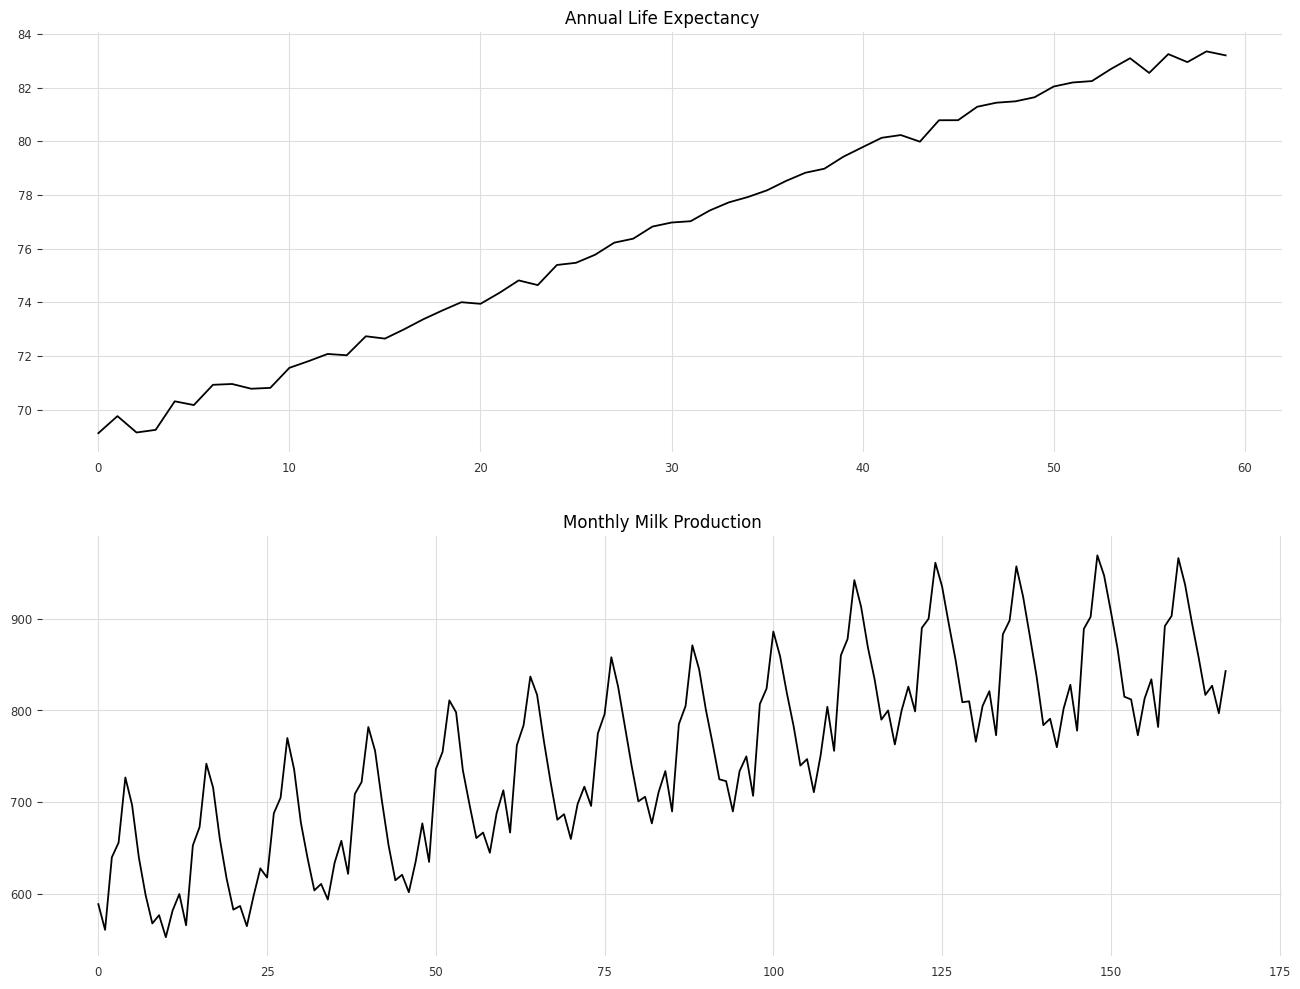

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', legend=False, ax=ax[1])

# Checking Stationarity

- Detect trend and seasonality with Augmented Dickey-Fuller Test

In [161]:
def check_stationarity(data):
  results = adfuller(data)[1:3]
  s = 'Non-Stationary'
  if results[0] < 0.05:
    s = 'Stationary'
  print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
  return (s, results[0])

  - ACF and PACF plots, which are used to determine the orders (parameters) for some of the models that will be used

  - The ACF and PACF can be plotted to help you identify if the time series process is an AR, MA, or an ARMA process (if both are present) and the significant lag values (for p and q).

  - We use the PACF plot to estimate the AR order and the ACF plot to estimate the MA order. Both the ACF and PACF plots show values that range from -1 to 1 on the vertical axis (y-axis), while the horizontal axis (x-axis) indicates the size of the lag. A significant lag is any lag that goes outside the shaded confidence interval

- First, we need to difference (detrend) the time series to make it stationary before applying the ACF and PACF plots.

- Life Expectancy Dataset:

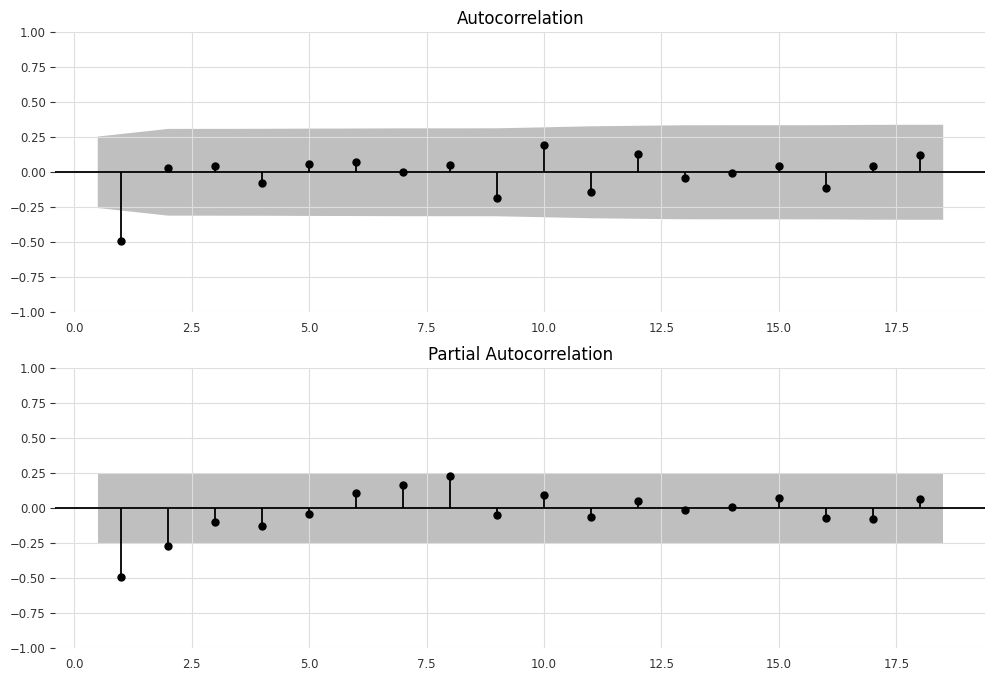

In [162]:
life_diff = life['value'].diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show()

  - The ACF plot shows a significant spike at lag (order) 1. Significance is represented when a lag (vertical line) goes above or below the shaded area. The shaded area represents the confidence interval, which is set to 95% by default. In the ACF plot, only the first lag is significant, which is below the lower confidence interval, and then cuts off right after. All the remaining lags are not significant. This indicates a moving average of order one or MA(1).

  - The PACF plot shows a gradual decay with oscillation. Generally, if PACF shows a gradual decay, it indicates a moving average model. For example, if you are using an ARMA or ARIMA model, it would be represented as ARMA(0, 1) once the data has been differenced to make it stationary, or ARIMA(0, 1, 1), indicating a first-order differencing with d=1. In both ARMA and ARIMA, the AR order is p=0, and the MA order is q=1.

- Montlhy Milk Dataset:

To make such time series stationary, you must start with seasonal differencing to remove the seasonal effect. Since the observations are taken monthly, the seasonal effects are observed annually (every 12 months or period):

In [163]:
milk_diff_12 = milk['production'].diff(12).dropna()

In [164]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.1607988052771125 	 lags:12


('Non-Stationary', 0.1607988052771125)

  - The differenced time series is still not stationary, so it is still needed to perform a second differencing. This time, we must perform first-order differencing (detrend). When the time series data contains seasonality and trend, is may needed to difference it twice to make it stationary.

In [165]:
milk_diff_12_1 = milk['production'].diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878848e-05 	 lags:11


('Stationary', 1.865423431878848e-05)

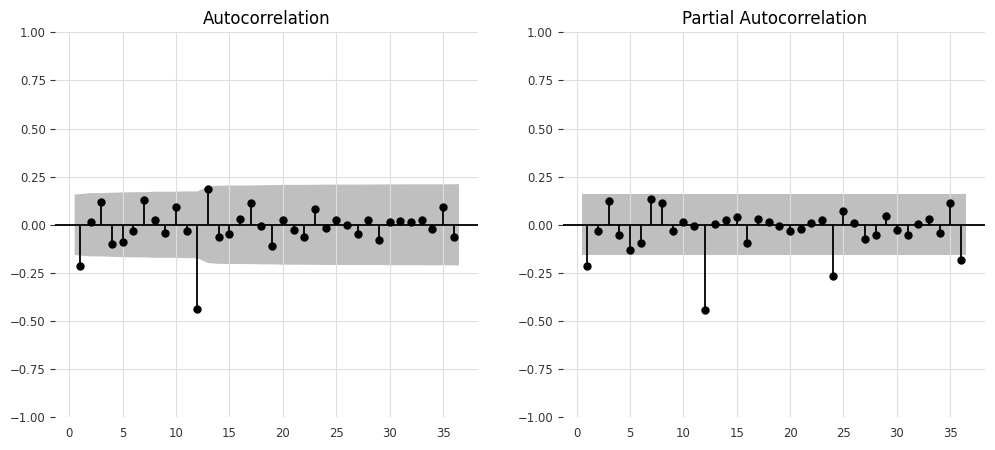

In [166]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.show()

  - For the seasonal orders, P and Q, you should diagnose spikes or behaviors at lags s, 2s, 3s, and so on, where s is the number of periods in a season. For example, in the milk
production data, s=12 (since there are 12 monthly periods in a season). Then, we observe for significance at 12 (s), 24 (2s), 36 (3s), and so on.

  - Starting with the ACF plot, there is a significant spike at lag 1, which represents the non-seasonal order for the MA process as q=1. The spike at lag 12 represents the seasonal
order for the MA process as Q=1. Notice that there is a cut-off right after lag 1, then a spike at lag 12, followed by a cut-off (no other significant lags afterward). These indicate
a moving average model: an MA(1) for the non-seasonal component and an MA(1) for the seasonal component. The PACF plot confirms this as well; an exponential decay at lags 12, 24, and 36 indicates an MA model. So, the SARIMA model would be ARIMA
(0, 1,1)(0, 1, 1, 12).

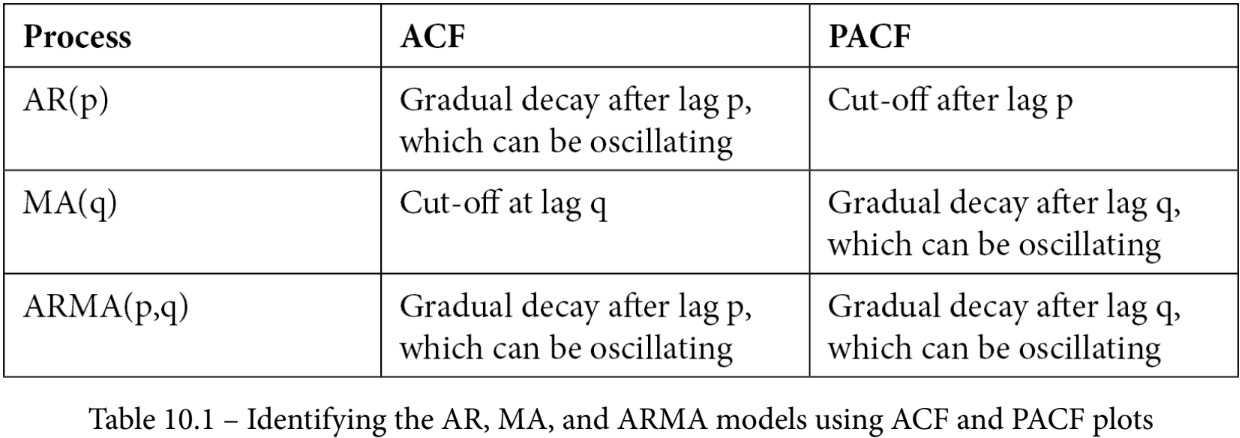

  - Now, if th model below captured all the information that's been embedded within the time series, you would expect the residuals to have no autocorrelation:

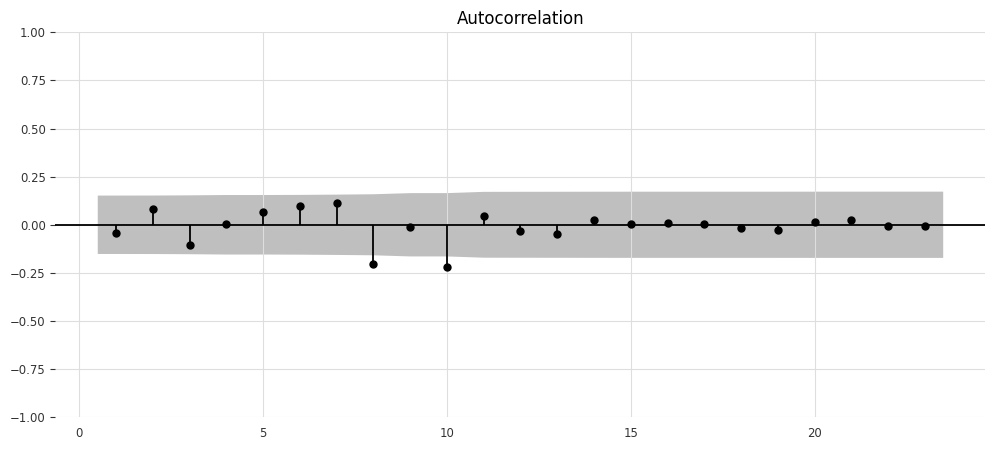

In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(milk['production'], order=(0,1,1), seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()

  - Overall, there are a couple of slightly significant lags, indicating the existence of some autocorrelation in the residuals. When the residuals show autocorrelation, this can mean that the model did not capture all the information, and there is potential for further improvement.

# Train/Test Split

  - Split the data into test and train datasets. To train the models (fitting) on the training dataset and use the test dataset to evaluate the model and compare your predictions. A forecast that's created for the data that will be used in training is called an in-sample forecast, while forecasting for unseen data such as a test set is called an out-of-sample forecast. When you're evaluating the different models, you will be using the out-of-sample or test sets.

In [168]:
def split_data(data, test_split):
  l = len(data)
  t_idx = round(l*(1-test_split))
  train, test = data[ : t_idx], data[t_idx : ]
  print(f'train: {len(train)} , test: {len(test)}')
  return train, test

In [169]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 51 , test: 9


#Hyperparameter Tuning


Evaluating Criteria:

  - Root Mean Squared Percentage Error (RMSPE)
  - Root Mean Square Error (RMSE)
  - Mean Square Error (MSE)
  - Akaike's Information Criteria (AIC)
  - Corrected Akaike's Information Criteria (AICc)
  - Bayesian Information Criteria (BIC)

In [170]:
def get_best_model(score, c='AIC'):
  initial_score = score[0][c]
  best_model = 0
  for k,v in score.items():
    if v[c] < initial_score:
      initial_score = v[c]
    best_model = k
  print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
  return score[best_model]['model']

  - A combinator utility function that takes a list of parameter values and returns a Cartesian product of these choices. You will use this when performing a grid search for hyperparameter tuning.
  
  - In grid search, you specify a combination of parameter values to train multiple models on each set and then evaluate the
winning model using the get_best_model function. For example, suppose your list contains three possible values for three different parameters. In such a case, the combinator function will return a list containing 3x3 or nine possible combinations.


In [171]:
def combinator(items):
  combo = [i for i in product(*items)]
  return combo

# Plot Forecast

Plotting the model object that we have trained, a starting position, and both the train and test datasets to create a plot that compares the forecast (predicted values) against actuals.

In [172]:
def plot_forecast(model, start, train, test):
  forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
  ax = train.loc[start:].plot(style='--')
  test.plot(ax=ax)
  forecast.plot(ax=ax, style = '-.')
  ax.legend(['orig_train', 'orig_test', 'forecast'])
  plt.show()

# Univariate Time Series Forecasting with Exponential Smoothing

In [173]:
from statsmodels.tsa.api import ExponentialSmoothing

- Life Expectancy dataset

In [174]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [175]:
life.columns

Index(['year', 'value'], dtype='object')

In [176]:
train = life_train['value'].values.ravel()
y = life_test['value'].values.ravel()
score = {}

for i, (t, dp) in enumerate(life_ex_comb):
  exp = ExponentialSmoothing(train,
                            trend=t,
                            damped_trend=dp,
                            seasonal=None)
  model = exp.fit(use_brute=True, optimized=True)
  y_hat = model.forecast(len(y))
  score[i] = {'trend':t,
              'damped':dp,
              'AIC':model.aic,
              'BIC':model.bic,
              'AICc':model.aicc,
              'RMSPE': rmspe(y, y_hat),
              'RMSE' : rmse(y, y_hat),
              'MAPE' : mape(y, y_hat),
              'model': model}

In [177]:
life_best_model = get_best_model(score, 'AIC')

Best model: 3 with lowest AIC score: -140.67026426265346


In [178]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,51
Model:,ExponentialSmoothing,SSE,2.805
Optimized:,True,AIC,-139.930
Trend:,Multiplicative,BIC,-132.203
Seasonal:,None,AICC,-138.021
Seasonal Periods:,None,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,22:21:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1818903,alpha,True
smoothing_trend,0.1818903,beta,True


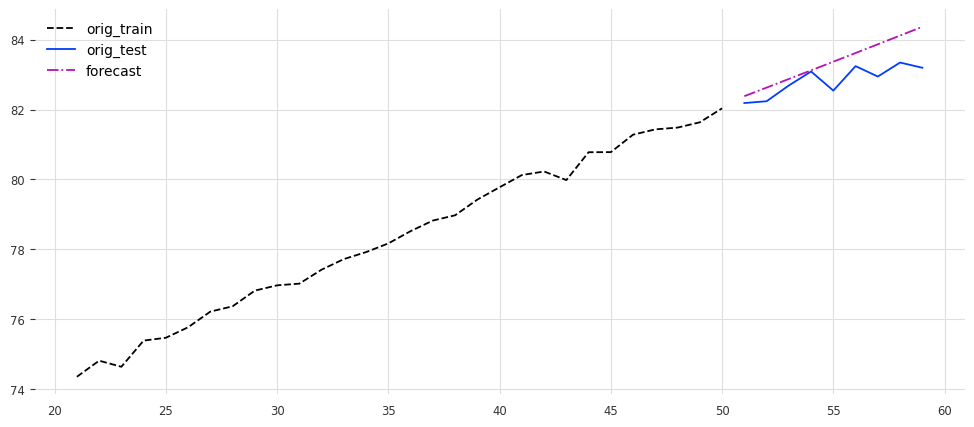

In [179]:
plot_forecast(life_best_model, '2000', life_train, life_test)

- Milk Production dataset

In [180]:
trend , damped= ['add', 'mul'], [True, False]
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [181]:
train = milk_train['production'].values.ravel()
y = milk_test['production'].values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
  exp = ExponentialSmoothing(train,
                              trend=t,
                              damped_trend=dp,
                              seasonal=s,
                              seasonal_periods=sp)
  model = exp.fit(use_brute=True, optimized=True)
  y_hat = model.forecast(len(y))
  milk_model_scores[i] = {'trend':t,
                          'damped':dp,
                          'AIC':model.aic,
                          'BIC':model.bic,
                          'AICc': model.aicc,
                          'RMSPE': rmspe(y, y_hat),
                          'RMSE' : rmse(y, y_hat),
                          'MAPE' : mape(y, y_hat),
                          'model': model}

In [182]:
milk_model = get_best_model(milk_model_scores)

Best model: 23 with lowest AIC score: 593.7138896839506


In [183]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,8461.633
Optimized:,True,AIC,615.505
Trend:,Multiplicative,BIC,662.910
Seasonal:,Multiplicative,AICC,621.021
Seasonal Periods:,12,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,22:21:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,6.0575e-10,beta,True


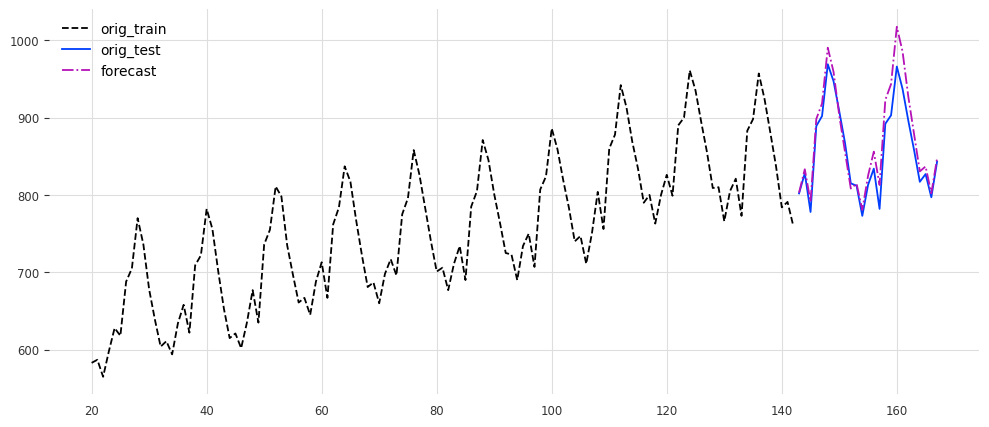

In [184]:
plot_forecast(milk_model, '1969', milk_train, milk_test)

  - The moving average model treats past values equally, while exponential smoothing type models put more emphasis (weight) on more recent observations. In other words, older observations decay in weight exponentially, hence the "exponential" term. This is based on the logical assumption that more recent events are likely to be more important than much older events; for example, what happened yesterday or the day before is more relevant than what happened 2 months ago for a daily time series.

## Darts Exponential Smoothing

In [185]:
!pip install darts

In [186]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

  - Darts expects the data to be an instance of the TimeSeries class, so you need to convert your pandas DataFrame before using it to train the model. The TimeSeries class provides the from_dataframe method, which you will be using:

In [187]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(),
                               time_col='month',
                               value_cols='production',
                               freq='MS')

train: 143 , test: 25


<Axes: xlabel='month'>

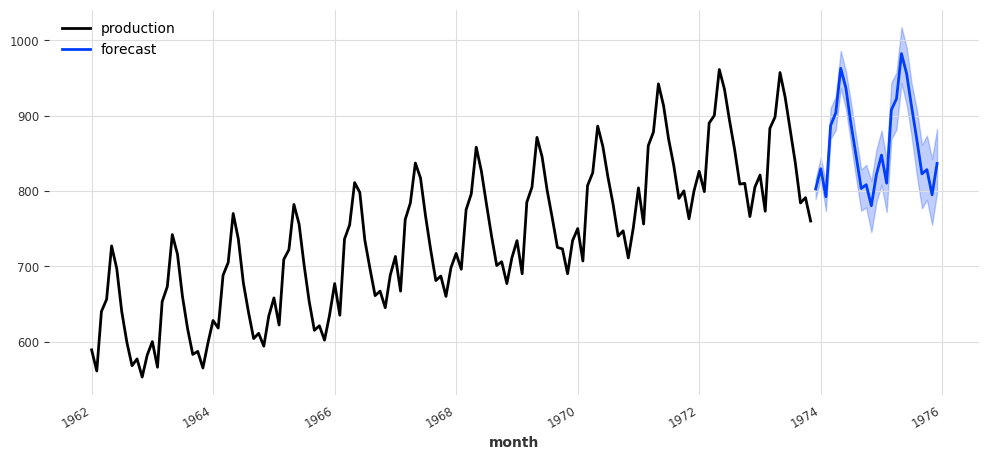

In [188]:
train, test = split_data(ts, 0.15)
model.fit(train)
forecast = model.predict(len(test), num_samples=100)
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

  - The darts library automated the evaluation process to find the optimal configuration(hyperparameters). Darts'ExponentialSmoothing class is a wrapper to statsmodels's
ExponentialSmoothing class, which means you have access to familiar methods and attributes, such as the .summary() method:

In [189]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 21 Dec 2023"
Box-Cox:,False,Time:,22:21:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


# Forecasting Univariate Time Series data with non-seasonal ARIMA

In [190]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [191]:
life.head()

,year,value
0,1960-01-01,69.123902
1,1961-01-01,69.760244
2,1962-01-01,69.149756
3,1963-01-01,69.248049
4,1964-01-01,70.311707


In [194]:
type(life['value'])

pandas.core.series.Series

## Chekcing Stationarity

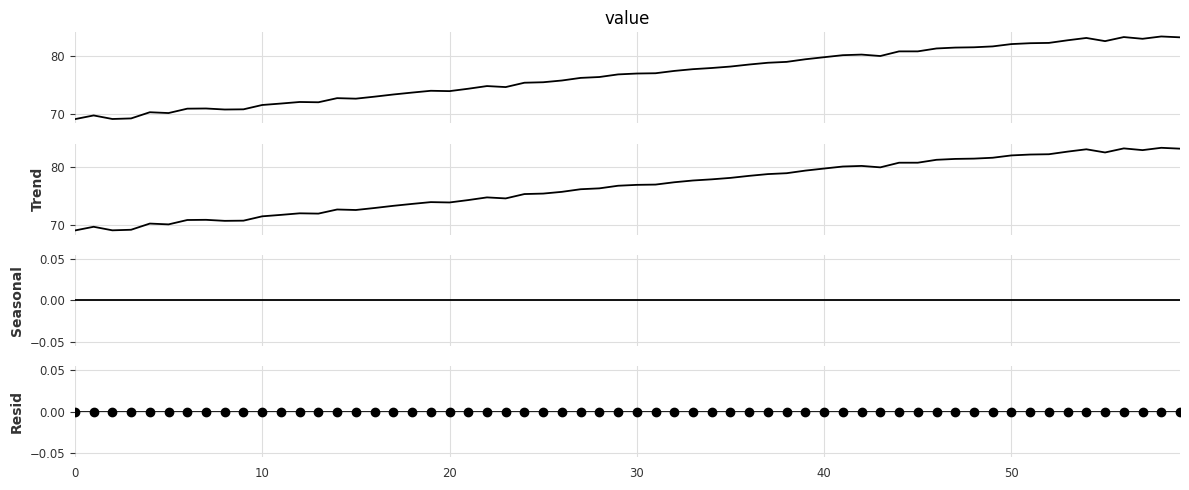

In [207]:
decomposed = seasonal_decompose(life['value'],
                                model='additive',
                                extrapolate_trend='freq',
                                period=1)
decomposed.plot(); plt.show()

Notice that the dataset shows a positive trend but no seasonality effect, as expected.

  - You will need to detrend the data first. Perform a first-order differencing and then test for stationarity


In [208]:
life_df1 = life['value'].diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.1737760312328632e-13 	 lags:1


('Stationary', 1.1737760312328632e-13)

  - Now, the data is stationary. The p-value is significant, and you can reject the null hypothesis. Note that the default periods value for diff is 1. Generally, diff(periods=n) is the difference between the current observation at period t and its lagged version at period t-n. In the case of diff(1) or diff(), the lagged version is t-1 (for example, the prior month's observation).

<Axes: >

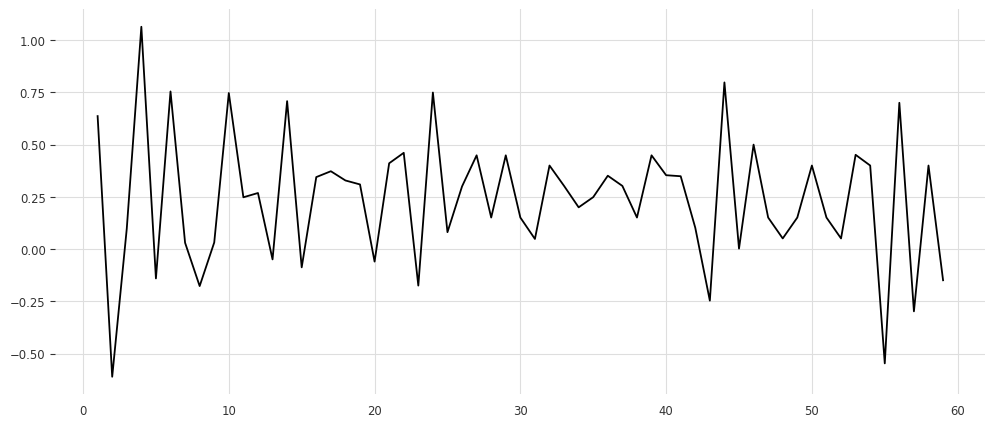

In [209]:
life_df1.plot()

## Checking ACF and PACF

  - The ACF and PACF plots will help you estimate the appropriate p and q values for the AR and MA models, respectively.

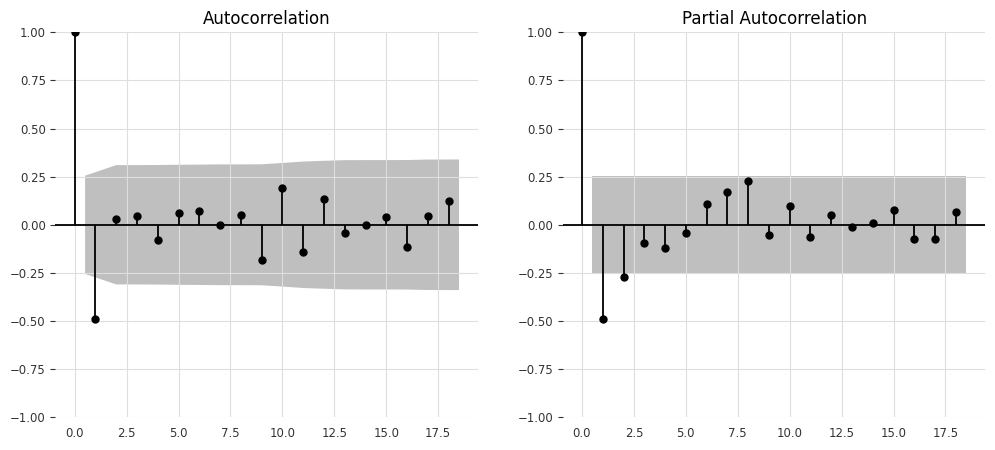

In [210]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]); plt.show()

  - In the preceding example, the zero lag was kept in the plot to help you visually compare past lags. The ACF and PACF at lag(0) are always one, so sometimes, it is removed from the plot since it does not provide any significance. Therefore, you must focus on lag(1) to determine its significance, as well as other prior lags that are of significance.

  - The ACF plot provides the significant lags for the MA(q) model. The ACF plot shows a cut-off after lag 1, indicating an MA(1) model.
  
  - The PACF plot provides the significant lags for the AR(p) model. There is a gradual decay with oscillation after lag 1, indicating a MA model at lag 1 or MA(1). This indicates a lack of an AR model, so the p order is zero or AR(0).

  - Now, we can build the ARIMA(p, d, q) model using these values to get an ARIMA(0,1,1).

## Fit Model

  - Train the ARIMA model on the training set, life_train, and inspect the model's summary. Don't use the differenced life_df1 version here since ARIMA will apply differencing based on the value of the d parameter. In this example, first-order differencing was satisfactory to detrend and make the data stationary, and you set d=1:

In [213]:
model = ARIMA(life_train['value'], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   51
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.632
Date:                Thu, 21 Dec 2023   AIC                             53.263
Time:                        22:53:32   BIC                             57.088
Sample:                             0   HQIC                            54.720
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0876      0.198      0.443      0.658      -0.300       0.475
sigma2         0.1568      0.032      4.928      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.93   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.00   Prob(JB):                         0.73
Heteroskedasticity (H):               0.46   Skew:                             0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating Model

  - We will need to validate the model's residuals to determine if the ARIMA model captured the signals in the time series. The assumption is that if the model captured all the information, the residuals from the model's prediction are random (noise) and do not follow a pattern. For example, we expect no autocorrelation in the residuals.

In [214]:
(acorr_ljungbox(results.resid,
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

  - The result shows 0, which is an aggregate of the results for the first 25 lags, indicating no autocorrelation.

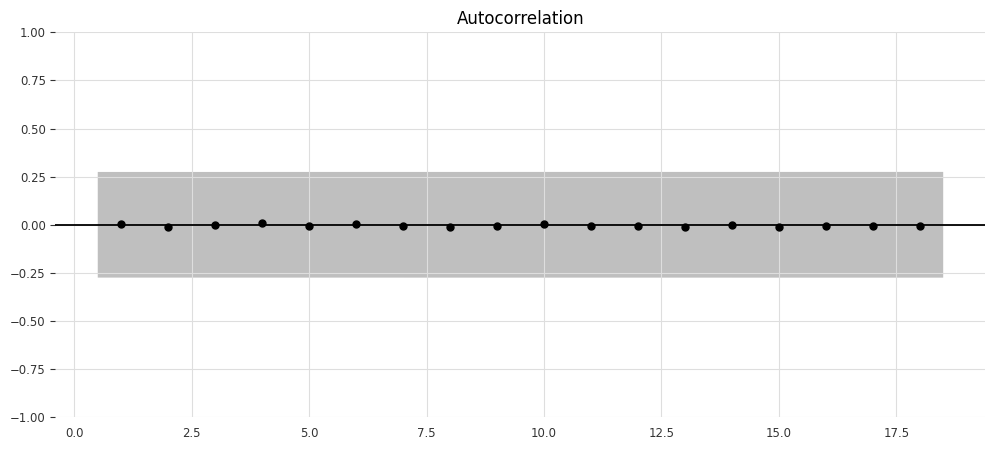

In [215]:
plot_acf(results.resid, zero=False);plt.show()

  - We can also inspect the distribution of the residuals. For example, we would expect normally distributed residuals with a mean of zero. We can use the QQPlot and Kernel Density Estimation (KDE) plot to observe the distribution and assess normality.

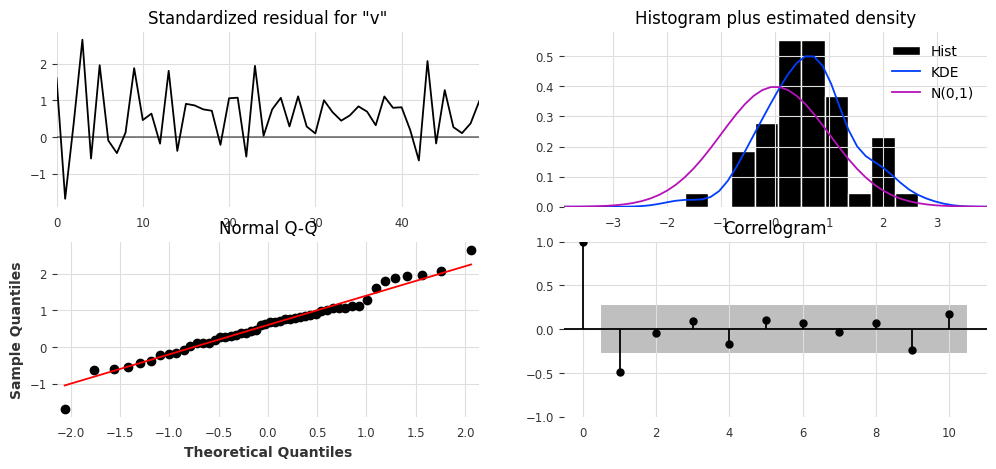

In [216]:
results.plot_diagnostics();plt.show()

  - The plots show a slight deviation from a normal distribution. For example, a perfect normally distributed dataset will have a perfect bell-curved KDE plot and all the
points will be perfectly aligned on the line in the QQPlot.

  - So far, the results and diagnostics indicate a decent model, though there might be room for improvements. Building an ARIMA model can be an iterative process that involves creating and testing different models.

  - The final step is to create a forecast (prediction) and compare it with test dataset (unseen or out of sample data).

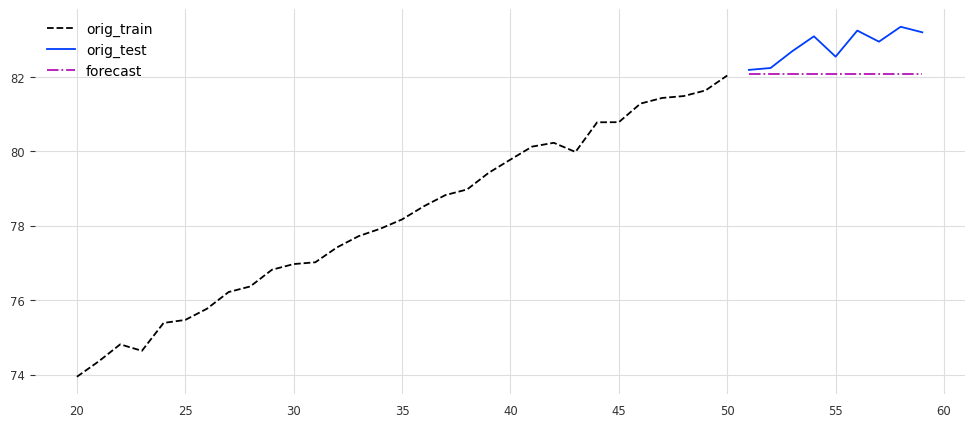

In [218]:
plot_forecast(results, '1998', life_train, life_test)

  - The dashed line (forecast) doesn't seem to follow the expected trend. We can compare this with the results from the exponential smoothing model, which did a much better
job. To resolve this, we can run multiple ARIMA models with different (p, d, q) values and compare the RMSE, MAPE, AIC, or BIC scores to pick the best-fitted model.

  - It isn't easy to identify if the time series is an MA or AR process or determine the optimal order (lag) values for p or q. We can use some tools such as naive grid search approach by trying different combinations for p, d, and q to train other ARIMA models before picking a winning model:

## Grid Search by hand

In [223]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
  m = ARIMA(life_train['value'], order=(p,d,q))
  res = m.fit()
  y = life_train['value'].values.ravel()
  y_hat = res.forecast(steps=len(y))
  score[i] = {'order': (p,d,q),
              'AIC':res.aic,
              'RMSPE': rmspe(y, y_hat),
              'BIC': res.bic,
              'AICc':res.aicc,
              'RMSE' : rmse(y, y_hat),
              'MAPE' : mape(y, y_hat),
              'model': res}
best_m = get_best_model(score, 'AIC')

Best model: 26 with lowest AIC score: 6.838788005569917


In [224]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,8,"(0, 2, 2)",6.838788,1.66067,12.514249,7.372121,12.427045,0.165163,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",8.651689,1.644599,16.299781,9.540578,12.294817,0.163397,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",8.778934,1.660123,16.346215,9.688025,12.422683,0.165105,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",10.58818,1.643258,20.148295,11.951817,12.283913,0.163251,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.191959,1.784062,22.651061,14.587308,13.415761,0.178099,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",18.809201,1.746722,26.376482,19.718292,13.125757,0.1743,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",22.595345,1.741851,28.270806,23.128679,13.086506,0.173793,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",24.703718,1.731968,32.351811,25.592607,13.007525,0.172767,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.034075,1.758262,34.817716,31.294945,13.214848,0.175471,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.166059,1.734248,38.902128,33.687798,13.022801,0.172978,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


  - The Akaike Information Criterion (AIC) is a metric that aims to find a balance between a model's maximum likelihood and a model's simplicity. Overly complex models can
sometimes overfit, meaning they can look like they learned but once they are presented with unseen data, they perform poorly. The AIC score penalizes as the number of parameters increases since they increase complexity

  - The Bayesian Information Criteria (BIC) is very similar to AIC but has a higher penalty term on the model's complexity. In general, the BIC penalty term is more significant,
so it can encourage models with fewer parameters than AIC does. Therefore, if ywe change the sorting or evaluation criteria from AIC to BIC, you may see different results. Simpler
models are preferred more with BIC

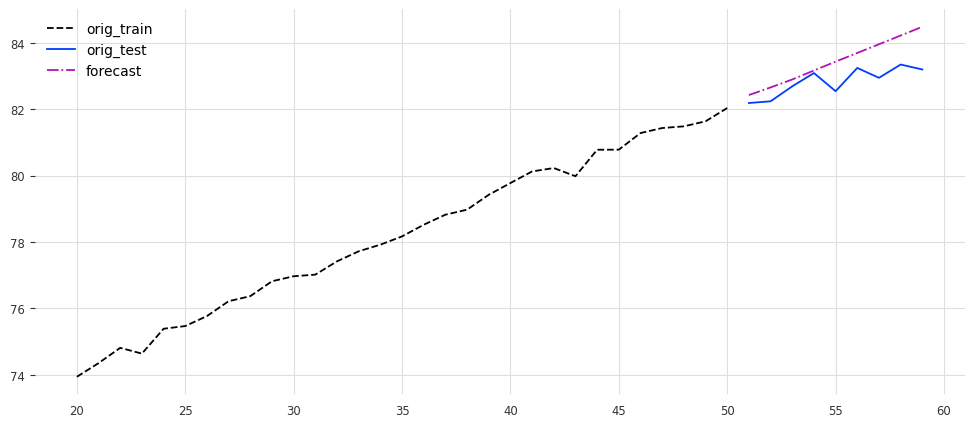

In [225]:
plot_forecast(best_m, '1998', life_train, life_test)

# Forecasting Univariate Time Series data with Seasonal ARIMA (SARIMA)

In [226]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

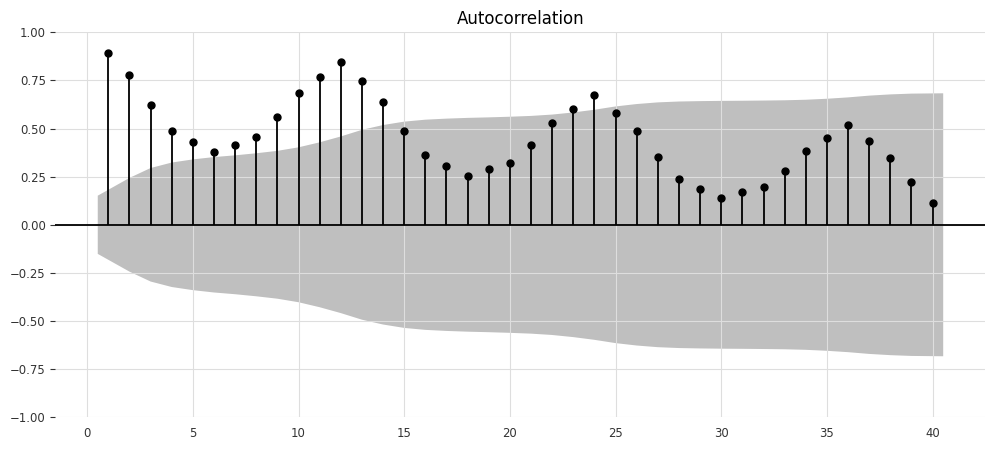

In [231]:
plot_acf(milk['production'], lags=40, zero=False);plt.show()

  - There is a repeating pattern of cycling spikes every 12 months (lags).

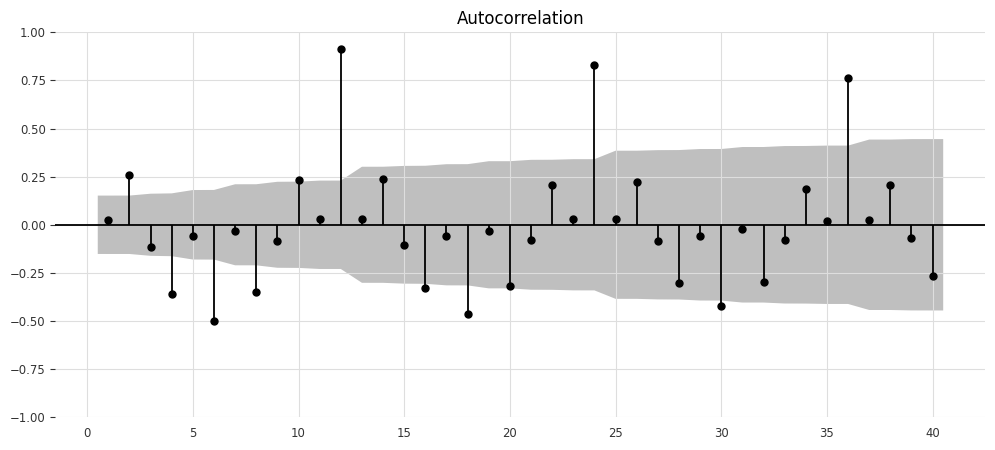

In [233]:
plot_acf(milk['production'].diff(1).dropna(), lags=40, zero=False);
plt.show()

  - This produced an ACF plot on the differenced data that makes the seasonal spikes more apparent:

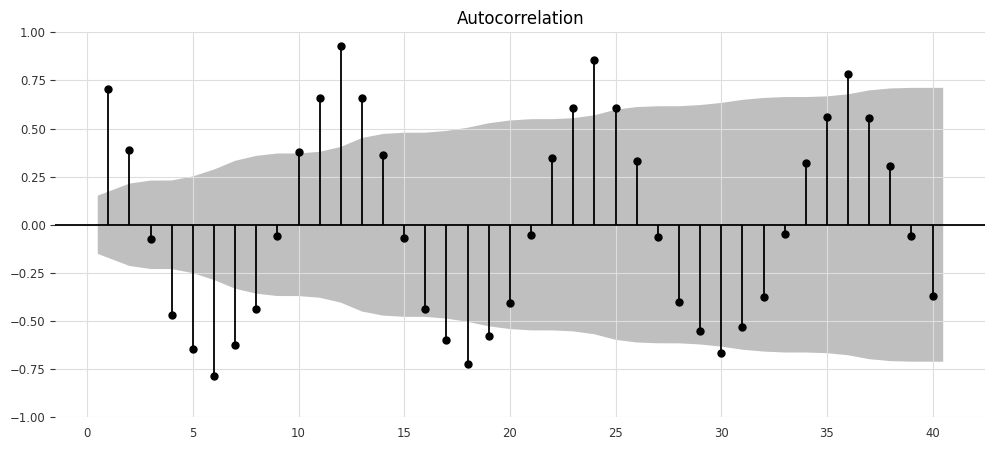

In [235]:
decomposed = seasonal_decompose(milk['production'], period=12, model='multiplicative')
milk_s = decomposed.seasonal
plot_acf(milk_s, zero=False, lags=40);plt.show()

  - Now we can use the check_stationarity function after differencing to determine if seasonal differencing was enough or not.

'Non-Stationary	 p-value:0.6274267086030311 	 lags:13


AttributeError: ignored

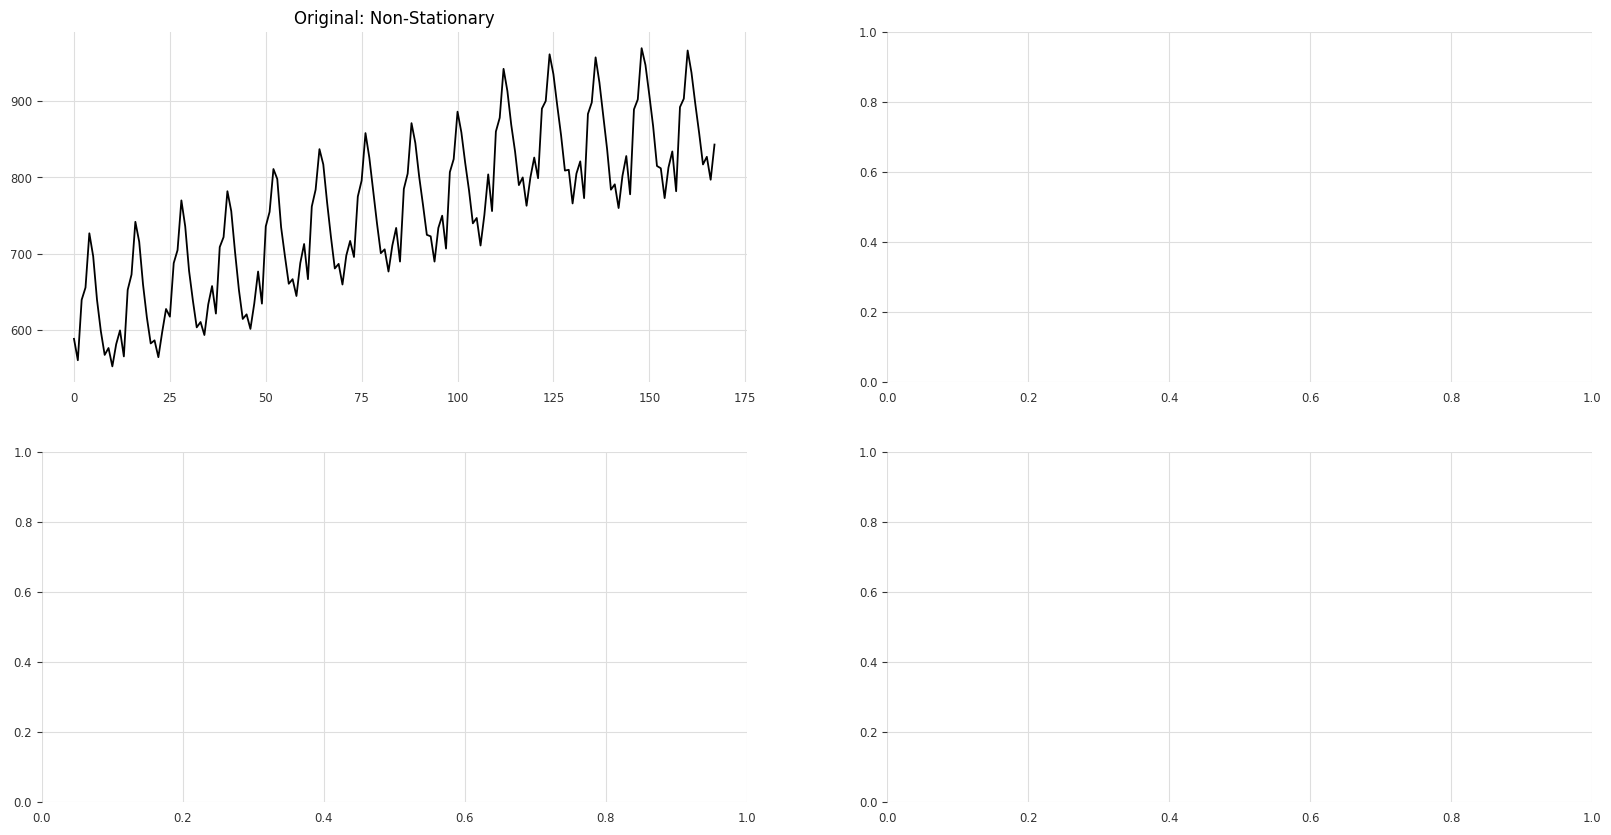

In [242]:
milk_dif_12 = milk['production'].diff(12).dropna()
milk_dif_12_1 = milk['production'].diff(12).diff(1).dropna()
sets = [milk['production'], milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize (Difference Once)', 'Differencing Twice']

fig, ax = plt.subplots(2,2, figsize=(20,10))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
  v, r = i // 2, i % 2
  outcome, pval = check_stationarity(d_set)
  d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}',legend=False)
  pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
  ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show()

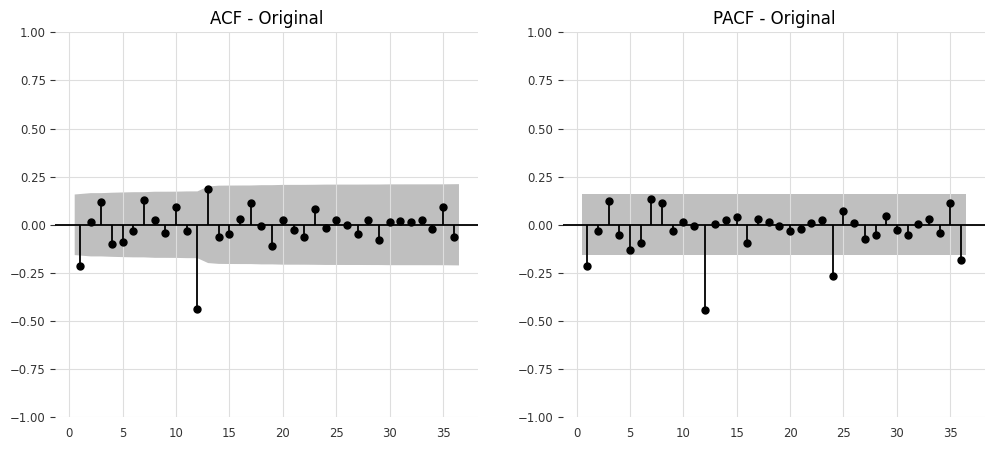

In [243]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

  - Starting with the ACF plot, there is a significant spike at lag 1, which represents the non-seasonal order for the MA process. The spike at lag 12 represents the seasonal
order for the MA process. Notice that there is a cut-off right after lag 1, then a spike at lag 12, followed by another cut-off (no other significant lags afterward). These are indications of a moving average model – more specifically, an order of q=1
and Q=1.

  - The PACF plot confirms this as well; an exponential decay at lags 12, 24, and 36 indicates an MA model. Here, the seasonal ARIMA would be ARIMA(0, 1,1)(0, 1, 1, 12).

In [245]:
sarima_model = SARIMAX(milk_train['production'],
                      order=(0,1,1),
                      seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

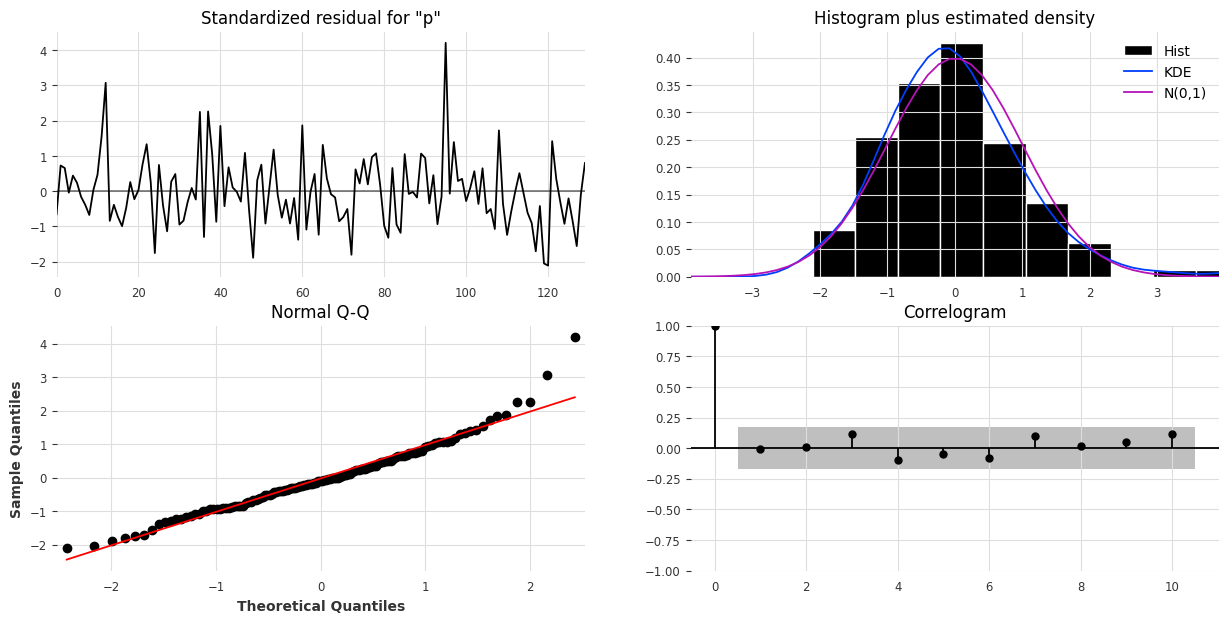

In [246]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [247]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 21 Dec 2023   AIC                            903.335
Time:                                    23:32:46   BIC                            911.938
Sample:                                         0   HQIC                           906.831
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

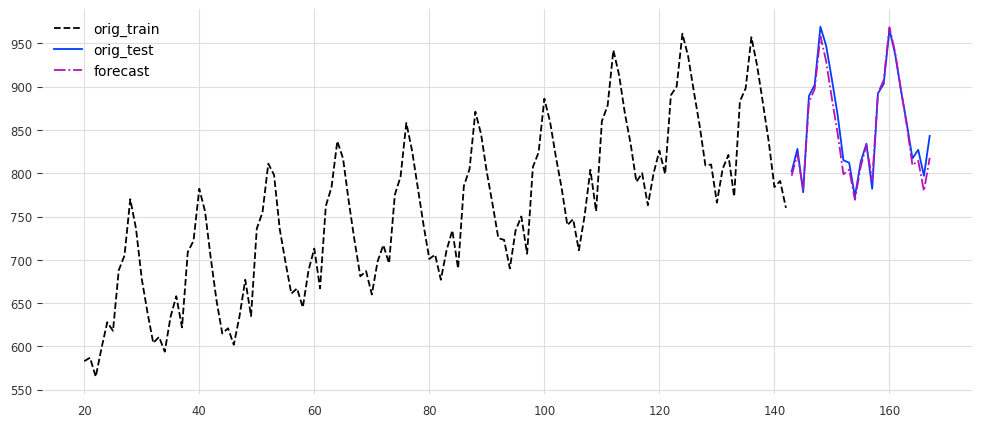

In [248]:
plot_forecast(model, '1971', milk_train, milk_test)

  - Overall, the SARIMA model did a great job of capturing the seasonal and trend effects.We can always iterate and test different values for (p, q) and (P, Q) by evaluating the
results using other metrics such as RMSE, MAPE, or AIC, to name a few.

  - Naive Grid Search by hand for SARIMA

In [251]:
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}

for i, (p, d, q, P, D, Q) in enumerate(vals):
  if i%15 == 0:
    print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train['production'],
    order=(p,d,q),
    seasonal_order=(P, D, Q, 12),
    enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test['production'].values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic,
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)


In [252]:
best_model = get_best_model(score, 'AIC')

Best model: 210 with lowest AIC score: 805.9162260288299


In [253]:
score[210]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 0),
 'AIC': 917.6638602303951,
 'AICc': 918.1638602303951,
 'BIC': 931.8452697651525,
 'RMSPE': 0.43226860128361205,
 'RMSE': 36.55109094074117,
 'MAPE': 0.03892087139444504,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7a31fa319270>}

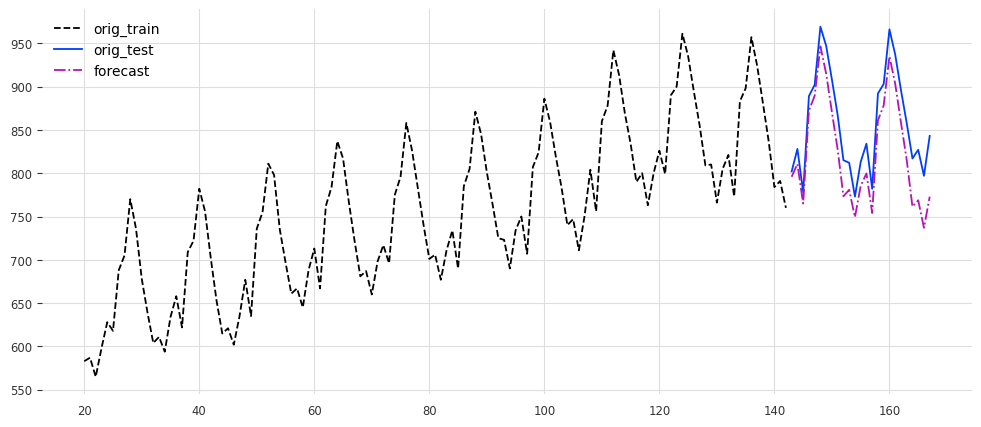

In [254]:
plot_forecast(best_model, '1962', milk_train, milk_test)